# Exploratory data analysis

This notebook provides an exploratory data analysis of the dataset. As a reminder, this dataset  - `Description des emplois salariés en 2021` is taken from the `Insee` website at the following link : <https://www.insee.fr/fr/statistiques/7651654#dictionnaire>.
We aim to study the effect of gender on labor outcomes, specifically on the level of wages and the number of hours worked.

Let's translate this in the PICO framework :

* **Population** : French individuals on the labor market in 2021
* **Intervention** : Gender being assigned at birth as female
* **Control** : Males on the labor market
* **Outcome** : Level of annual net wages and number of hours worked



This code provides a first glance at the structure of our data.

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import MultiPolygon
from tqdm import tqdm
import gdown
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode
init_notebook_mode(connected= True)
import plotly.express as px
import seaborn as sns

`Warning` : This code should be run after the [import and formating notebook](test_import_données.ipynb).

In [3]:
base = pd.read_csv("INSEE_DATA_TREATED.csv", delimiter=",")

C:\Users\grnma\AppData\Local\Temp\ipykernel_17344\3172684118.py:1: DtypeWarning:

Columns (1,2,4,25,32,33) have mixed types. Specify dtype option on import or set low_memory=False.



In [3]:
base.head()

,Unnamed: 0,A6,A17,A38,CPFD,DATDEB,DATFIN,DEPR,DEPT,DOMEMPL,...,DOMEMPL_EM_N,DOMEMPL_N,REGR_N,REGT_N,CS_N,DEPR_N,DEPT_N,WAGE,UNEMP,A38_N
0,0,BE,C5,CG,C,1.0,360.0,49,49,9.0,...,Autres sociétés privées,Autres sociétés privées,Pays de la Loire,Pays de la Loire,Ouvriers non qualifiés de type industriel,Maine-et-Loire,Maine-et-Loire,20000,NaN,Fabrication de produits en caoutchouc et en pl...
1,1,BE,C5,CG,C,31.0,360.0,53,35,9.0,...,Autres sociétés privées,Autres sociétés privées,Pays de la Loire,Bretagne,Ouvriers non qualifiés de type industriel,Mayenne,Ille-et-Vilaine,14000,NaN,Fabrication de produits en caoutchouc et en pl...
2,2,BE,C5,CG,C,1.0,360.0,59,59,9.0,...,Autres sociétés privées,Autres sociétés privées,Nord – Pas-de-Calais – Picardie,Nord – Pas-de-Calais – Picardie,Ingénieurs et cadres techniques d'entreprises,Nord,Nord,30000,NaN,Fabrication de produits en caoutchouc et en pl...
3,3,BE,C5,CG,C,288.0,360.0,62,62,9.0,...,Autres sociétés privées,Autres sociétés privées,Nord – Pas-de-Calais – Picardie,Nord – Pas-de-Calais – Picardie,Ouvriers non qualifiés de type industriel,Pas-de-Calais,Pas-de-Calais,3000,NaN,Fabrication de produits en caoutchouc et en pl...
4,4,BE,C5,CG,C,1.0,360.0,66,66,9.0,...,Autres sociétés privées,Autres sociétés privées,Languedoc-Roussillon – Midi-Pyrénées,Languedoc-Roussillon – Midi-Pyrénées,Ouvriers qualifiés de type industriel,Pyrénées-Orientales,Pyrénées-Orientales,20000,NaN,Fabrication de produits en caoutchouc et en pl...


In [4]:
base.columns

Index(['Unnamed: 0', 'A6', 'A17', 'A38', 'CPFD', 'DATDEB', 'DATFIN', 'DEPR',
       'DEPT', 'DOMEMPL', 'DOMEMPL_EM', 'DUREE', 'FILT', 'REGR', 'REGT',
       'SEXE', 'PCS', 'TYP_EMPLOI', 'CONV_COLL', 'NBHEUR', 'NBHEUR_TOT', 'AGE',
       'TRNNETO', 'TRALCHT', 'TREFF', 'CONT_TRAV', 'CS', 'AGE_TR', 'DATDEB_TR',
       'DATFIN_TR', 'DUREE_TR', 'POND', 'DOMEMPL_EM_N', 'DOMEMPL_N', 'REGR_N',
       'REGT_N', 'CS_N', 'DEPR_N', 'DEPT_N', 'WAGE', 'UNEMP', 'A38_N'],
      dtype='object')

Further explanations on the meaning of the variables and their type :

In [12]:
numerical_columns = [
    'DATDEB', 'DATFIN', #date début et fin de rémunération par rapport au 01/01
     'AGE', #age en années
     'POND', #pondération 1/12e
    'DUREE', #durée de paie en jours
      'NBHEUR', 'NBHEUR_TOT', #nombre d'heures salariées total (quelle diff?)
    'WAGE', #transformation of TRNNETO
    'UNEMP' #transformation of TRALCHT
]
categorical_columns = [
    'A6', 'A17', 'A38', #activité en nomenclature agrégrée
    'CPFD', #temps complet ou partiel
    'DEPR', 'DEPT', #département résidence et travail
    'DOMEMPL', 'DOMEMPL_EM', #domaine de l'emploi et l'établissement d'affectation/employeur
    
    'FILT', #indic poste annexe 2 ou non-annexe 1 (seuils rémunération volume)
    'REGR', 'REGT', #région de résidence et de travail
    'SEXE', #1 homme 2 femme
    'PCS', #PCS-ESE
    'TYP_EMPLOI', #ordinaire, apprenti, autre
    'CONV_COLL', #convention collective
  
    'TRNNETO', #rémunération nette globale en tranches -> à passer en numérique ?
    'TRALCHT', #total des indémnités de chômage, en tranches -> passage en numérique ?
    'TREFF', #tranche d'effectif : de 0 à 250+ postes
    'CONT_TRAV', #contrat de travail : APP apprentissage, TOA occasionnel ou à l'acte, TTP intérim, AUTre
    'CS', #CSP mais code plus simple 
    'AGE_TR', #age en tranches quadriennales
    'DATDEB_TR',
       'DATFIN_TR', #dates début et fin rémunération en tranches
    'DUREE_TR', #durée de paie exprimée en jours en tranches mensuelles
    'DOMEMPL_EM_N', 'DOMEMPL_N', 'REGR_N',
       'REGT_N', 'CS_N', 'DEPR_N', 'DEPT_N','A38_N' #les variables renommées avec les labels correspondants aux codes
]
all_columns = numerical_columns + categorical_columns

In [5]:
#The dataset is very large :
print(f"Number of rows : {base.shape[0]}, number of columns : {base.shape[1]}")

Number of rows : 2403775, number of columns : 42


### Identification Assumptions

As seen in class, four different assumptions need to be met for the PICO framework to stand. Let's discuss them in our data.

**Unconfoundedness** requires the treatment to be as good as random given the covariates, that is to say :

$$
(Y(1), Y(0)) \perp \!\!\! \perp A \ | \ X
$$

This assumption is likely not verified in this dataset, because we lack covariates such as education, a strong predictor for the wage level as well as for the number of hours worked. One could argue, however, that the socio-professionnal category (CSP) is a proxy of education.

Since unconfoundedness is equivalent to 

$$
(Y(1), Y(0)) \perp \!\!\! \perp A \ | \ e(X) = \mathbb{P}(\text{Female}) \ |\ X
$$

we can check if our covariates are balanced regarding the propensity score.

In [ ]:
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *
sns.set(rc={'figure.figsize':(10,8)}, font_scale = 1.3)

base_modified= base.copy()
base_modified['SEXE'] = base['SEXE'].replace({1: 0, 2: 1})
base_modified = base_modified.dropna().sample(frac = 0.01)

excluded_cols = [col for col in categorical_columns if col != 'SEXE'] + ['WAGE', 'NBHEUR', 'NBHEUR_TOT']
psm = PsmPy(base_modified, treatment='SEXE', exclude = excluded_cols, indx = "Unnamed: 0")

1 % of the dataset has been selected for the matching process in order for the code to run in a reasonable time.

In [40]:
psm.logistic_ps(balance = True)

In [41]:
psm.knn_matched(matcher='propensity_logit', replacement=False, caliper=None, drop_unmatched=True)

c:\Users\grnma\OneDrive\Bureau\ENSAE\3A\S2\ML for econometrics\project\ML-for-econometrics---Project\venv\Lib\site-packages\psmpy\psmpy.py:363: UserWarning:

Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False



As shown on the graph below, the propensity score is not balanced through the treatment and control groups, because the standardized means of numerical covariates are unequal after the matching process. This may indicate that this hypothesis is not valid, and therefore that any further analysis may not identify a causal relationship.

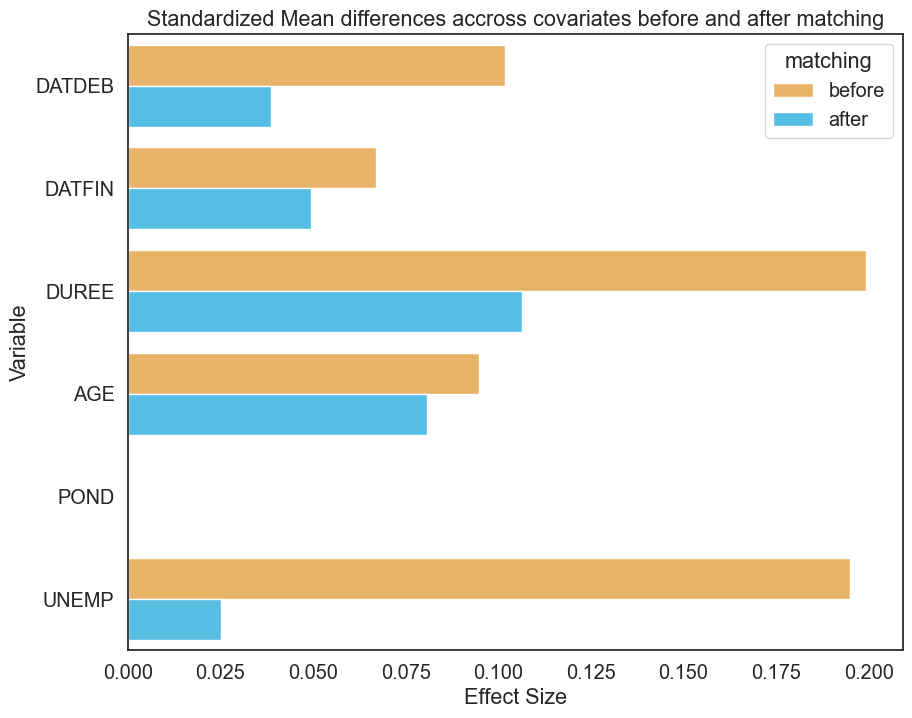

In [47]:
psm.effect_size_plot(title='Standardized Mean differences accross covariates before and after matching', before_color='#FCB754', after_color='#3EC8FB', save=False)

In [ ]:
psm.predicted_data

,Unnamed: 0,DATDEB,DATFIN,DUREE,AGE,POND,UNEMP,propensity_score,propensity_logit,SEXE
0,1140508,55.0,210.0,147.0,49.0,12,0.0,0.493940,-0.024240,1
1,1216377,18.0,350.0,111.0,23.0,12,1500.0,0.494242,-0.023033,1
2,798225,1.0,150.0,150.0,40.0,12,500.0,0.484700,-0.061220,1
3,2099197,1.0,360.0,360.0,39.0,12,0.0,0.608901,0.442695,1
4,1319477,1.0,360.0,360.0,39.0,12,1500.0,0.600189,0.406252,1
...,...,...,...,...,...,...,...,...,...,...
2664,1158672,253.0,360.0,107.0,41.0,12,4000.0,0.454304,-0.183296,0
2665,1167836,98.0,326.0,192.0,37.0,12,200.0,0.518538,0.074186,0
2666,1141876,164.0,207.0,42.0,49.0,12,6000.0,0.355865,-0.593355,0
2667,1215508,188.0,349.0,48.0,23.0,12,0.0,0.501691,0.006765,0


One can also check the overlapping hypothesis, by checking if the treatment is not deterministic given the set of covariates.

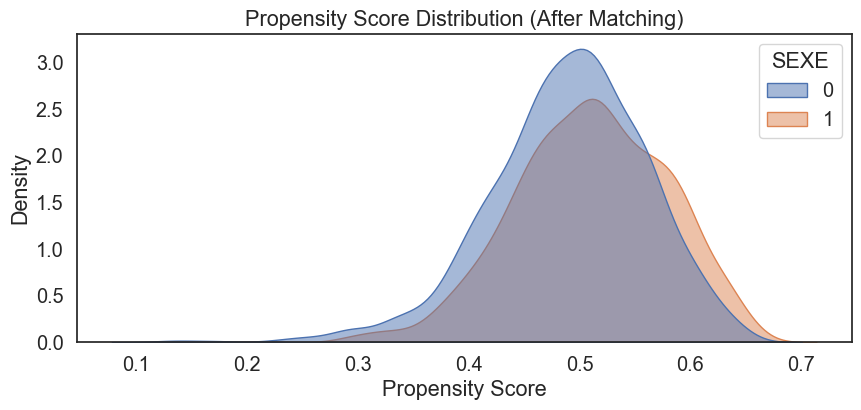

In [75]:
plt.figure(figsize = (10, 4))
sns.kdeplot(data=psm.predicted_data, x='propensity_score', hue='SEXE', fill=True, alpha=0.5)
plt.title("Propensity Score Distribution (After Matching)")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.show()

The distributions overlap, so the matching is of good quality : treatment and control individuals have similar propensity scores. The tail differences between the two suggest that some individuals lack close matches, which was expected given the output of the KNN algorithm.

The consistency assumption relies on the observed outcome being the potential outcome of the treatment for the unit i. In practice, this assumption should be verified in the vast majority of cases, apart from a few datapoints being misspecified.

The generalization assumption will be verified in the modelling notebooks, for instance by using cross-validation to fit and evaluate the accuracy of our models.

### Descriptive analysis

One of our main target variables is the wage of our individuals. In the dataset, wage is coded as a categorical variable.

In [59]:
#WAGE has been preprocessed. We chose to keep the lower bound of the each wage range.
base['WAGE'].sort_values().unique()

array([    0,   200,   500,  1000,  1500,  2000,  3000,  4000,  6000,
        8000, 10000, 12000, 14000, 16000, 18000, 20000, 22000, 24000,
       26000, 28000, 30000, 35000, 40000, 50000])

Text(0.5, 1.0, 'Distribution of the "WAGE" variable')

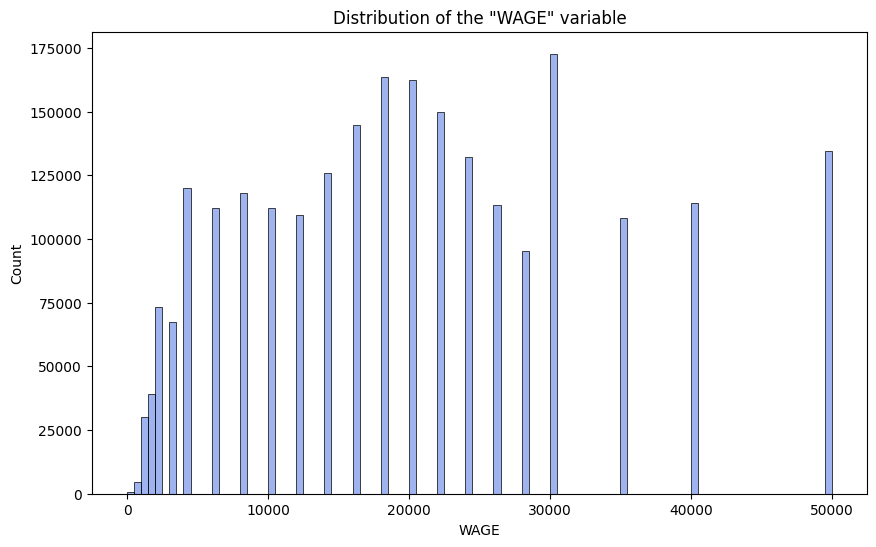

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(base['WAGE'], bins=100, color = 'royalblue', alpha = 0.5)
plt.title('Distribution of the "WAGE" variable')

Such histogramms can be plotted with other variables

Text(0.5, 1.0, 'Distribution of the age')

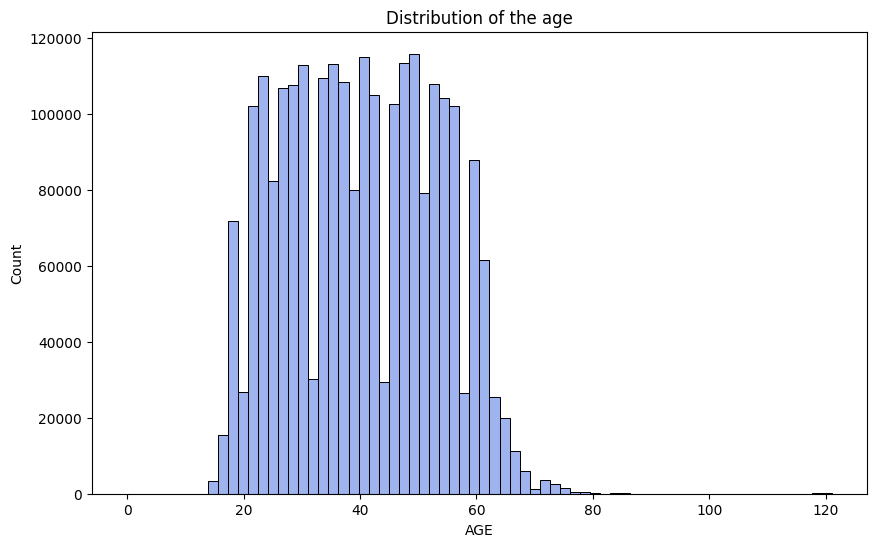

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(base['AGE'], bins=70, color = 'royalblue', alpha = 0.5)
plt.title('Distribution of the age')

Text(0.5, 1.0, "Distribution of 'AGE_TR' : age in slices of 4 years")

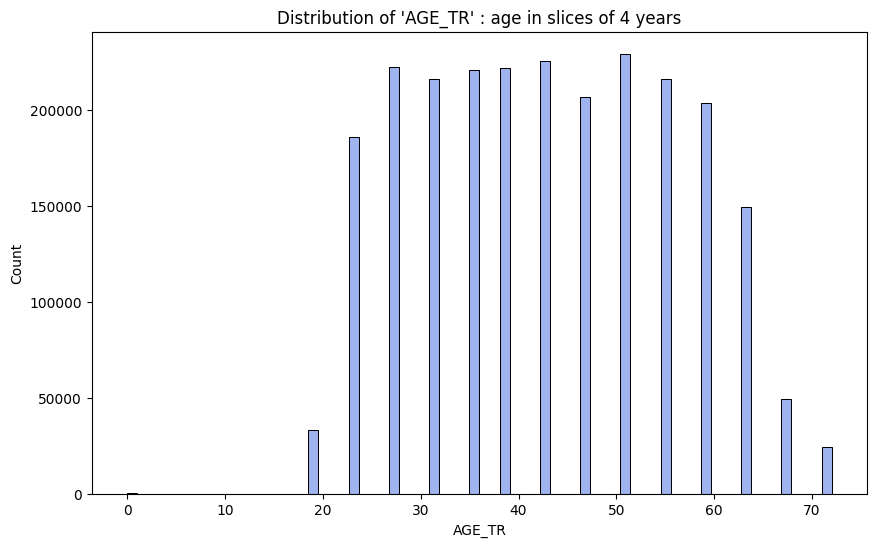

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(base['AGE_TR'], bins=70, color = 'royalblue', alpha = 0.5)
plt.title("Distribution of 'AGE_TR' : age in slices of 4 years")

One can also better grasp the fluctuations on the labor market, usign the 'DATDEB' and 'DATFIN' columns which give the start and end dates of the employment period. 'DUREE' might also be useful in that case.

In [11]:
print(f"Proportion of individuals with DUREE = 360 days : {round(base[base['DUREE'] == 360].shape[0] / base.shape[0], 3)}")

Proportion of individuals with DUREE = 360 days : 0.6


In [12]:
#Print the proportion of individuals with DATDEB = 1 and DATFIN = 365
print(f"Proportion of individuals with DATDEB = 1 and DATFIN = 360 : {round(base[(base['DATDEB'] == 1) & (base['DATFIN'] == 360)].shape[0] / base.shape[0], 3)}")

Proportion of individuals with DATDEB = 1 and DATFIN = 360 : 0.619


In [13]:
print(f"Average duration between DATDEB and DATFIN for individuals with |DATDEB - DATFIN| != 360 : {round(base[base['DATDEB'] != 1]['DATFIN'].mean(), 2)}")

Average duration between DATDEB and DATFIN for individuals with |DATDEB - DATFIN| != 360 : 320.5


We are interested in the link between the wage level and the gender of any given individual, controlling on the other variables we have available. First, one can see that gender has a great influence over the average wage level and on the field of work.

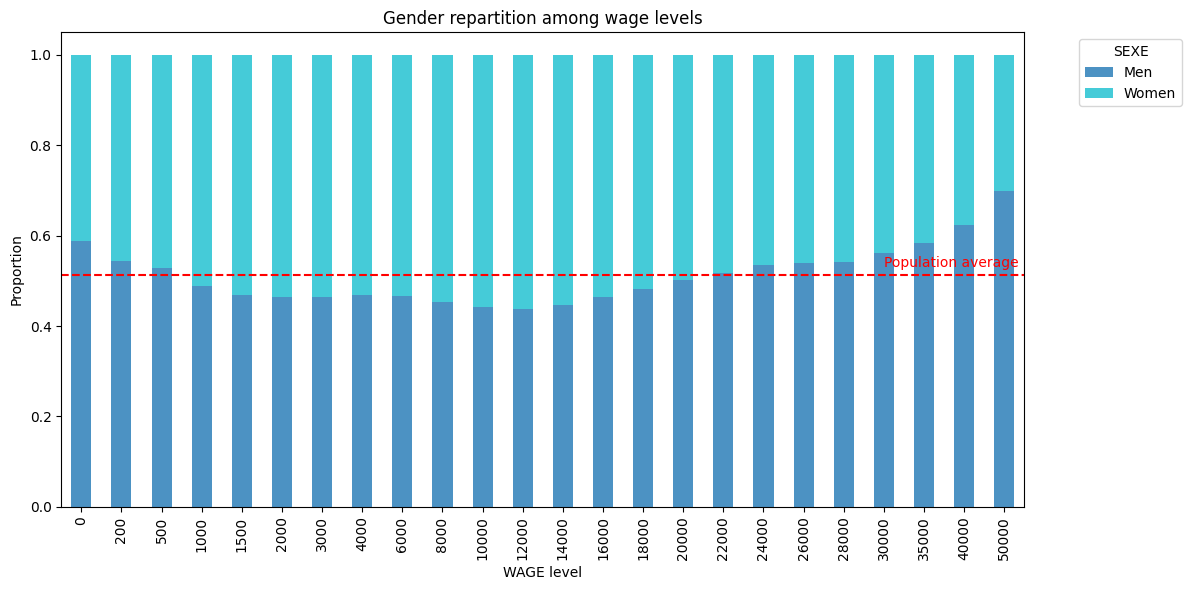

In [14]:
#Plot the stacked barplot of 'WAGE' levels depending on 'SEXE'
wage_sexe_counts = base.groupby(['WAGE', 'SEXE']).size().unstack(fill_value=0)
wage_sexe_proportions = wage_sexe_counts.div(wage_sexe_counts.sum(axis=1), axis=0)
wage_sexe_proportions.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab10', alpha=0.8)

plt.title('Gender repartition among wage levels')
plt.xlabel('WAGE level')
plt.ylabel('Proportion')
legend_labels = ['Men', 'Women']  # Map 1 -> Men, 2 -> Women
plt.legend(title='SEXE', labels=legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axhline(0.512, color='red', linestyle='dashed')
plt.annotate('Population average', xy=(0, 0.512), xytext=(20, 0.53), color='red')

plt.tight_layout()

plt.show()

Women are over-represented in wages ranging from 1000€ to 22000€ net annual earnings. They account only for 30% of the highest earning category (>50 000€).

In [15]:
wage_sum_by_sexe = base.groupby('SEXE')['WAGE'].sum()
count_by_sexe = base.groupby('SEXE')['WAGE'].count()
average_wage_by_sexe = wage_sum_by_sexe / count_by_sexe
print("\nAverage wage per person by SEXE:")
print(average_wage_by_sexe)


Average wage per person by SEXE:
SEXE
1    21334.139711
2    18178.615886
Name: WAGE, dtype: float64


On average, women earn roughly 3000 € less than men in our dataset.
<br>

One can suppose that gap shall be explained by a difference in the hours worked between both gender groups.

In [16]:
from scipy.stats import ttest_ind

C:\Users\grnma\AppData\Local\Temp\ipykernel_16708\585221897.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\grnma\AppData\Local\Temp\ipykernel_16708\585221897.py:7: UserWarning:

The palette list has more values (10) than needed (2), which may not be intended.



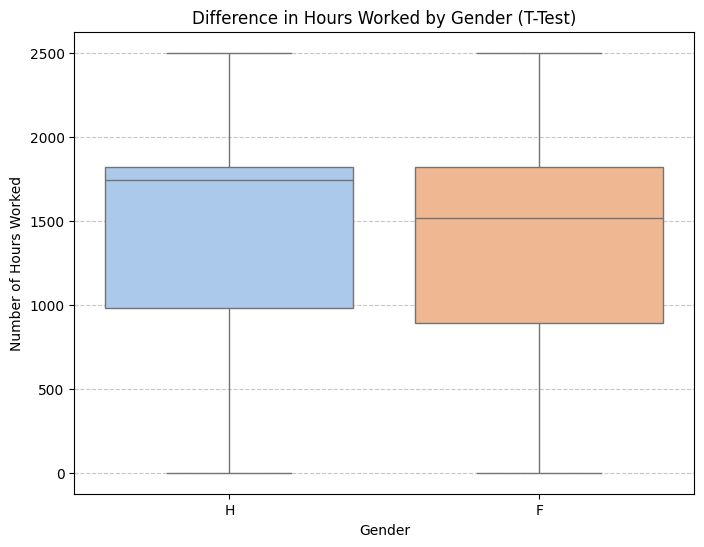

In [17]:
men_hours = base[base['SEXE'] == 1]['NBHEUR'].dropna()
women_hours = base[base['SEXE'] == 2]['NBHEUR'].dropna()

t_stat, p_value = ttest_ind(men_hours, women_hours, equal_var=False)  # Welch’s t-test (does not assume equal variance)

plt.figure(figsize=(8, 6))
sns.boxplot(x='SEXE', y='NBHEUR', data=base, palette=sns.color_palette("pastel"), showfliers=False)

# Labels and title
plt.title("Difference in Hours Worked by Gender (T-Test)")
plt.xlabel("Gender")
plt.ylabel("Number of Hours Worked")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(ticks=[0, 1], labels=["H", "F"]) 


# Show the plot
plt.show()

C:\Users\grnma\AppData\Local\Temp\ipykernel_16708\51467237.py:7: UserWarning:

The palette list has more values (10) than needed (2), which may not be intended.



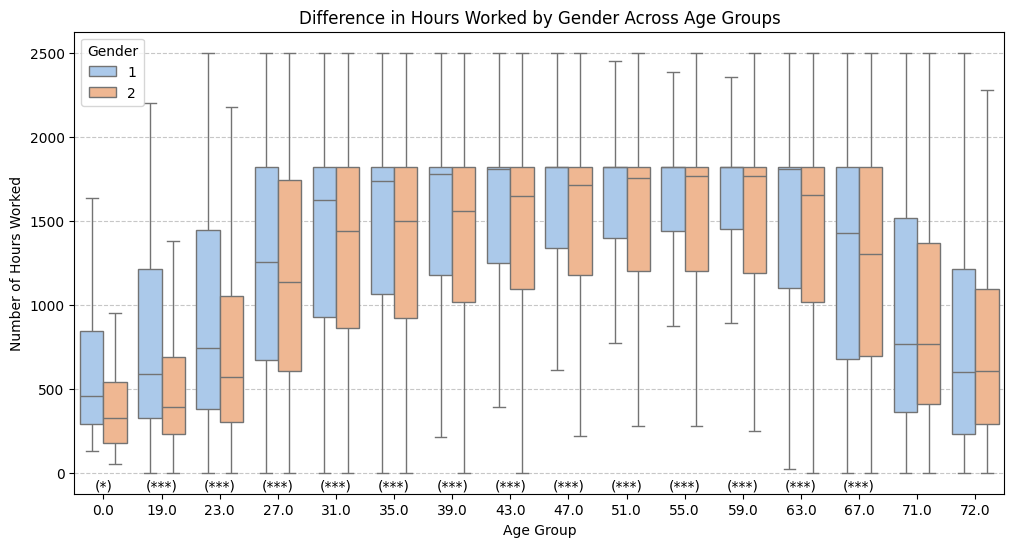

In [ ]:
age_groups = sorted(base['AGE_TR'].dropna().unique())
age_labels = []


plt.figure(figsize=(12, 6))
sns.boxplot(data=base, x='AGE_TR', y='NBHEUR', hue='SEXE', 
            palette=sns.color_palette("pastel"), showfliers=False)

# T-Test for every age_group
for i, age_group in enumerate(age_groups):
    group_data = base[base['AGE_TR'] == age_group]
    men_hours = group_data[group_data['SEXE'] == 1]['NBHEUR'].dropna()
    women_hours = group_data[group_data['SEXE'] == 2]['NBHEUR'].dropna()
    
    if len(men_hours) > 1 and len(women_hours) > 1:
        t_stat, p_value = ttest_ind(men_hours, women_hours, equal_var=False) #Welch T-test 

        # Convert p-value into significance stars
        if p_value < 0.001:
            p_text = "(***)"
        elif p_value < 0.01:
            p_text = "(**)"
        elif p_value < 0.05:
            p_text = "(*)"
        else:
            p_text = ""  # Not significant
    else:
        p_text = ""  # Not enough data

    # * display options
    if p_text:
        plt.text(i, -100, p_text, 
                 horizontalalignment='center', fontsize=10, color='black')



plt.title("Difference in Hours Worked by Gender Across Age Groups")
plt.xlabel("Age Group")
plt.ylabel("Number of Hours Worked")
plt.legend(title="Gender")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

As expected, the wealth difference between both gender groups is partly explained by the number of hours worked. Testing if the means are equal, the null hypothesis is rejected for almost every age group, apart for individuals aged 71 or more. Note that the 3rd quartile is equal accross boxplots for everyone between 31 and 67 - it can be explained by the maximum legal amount of hours worked.

This point can also be made regarding the type of contracts proposed for each gender group, as displayed below.

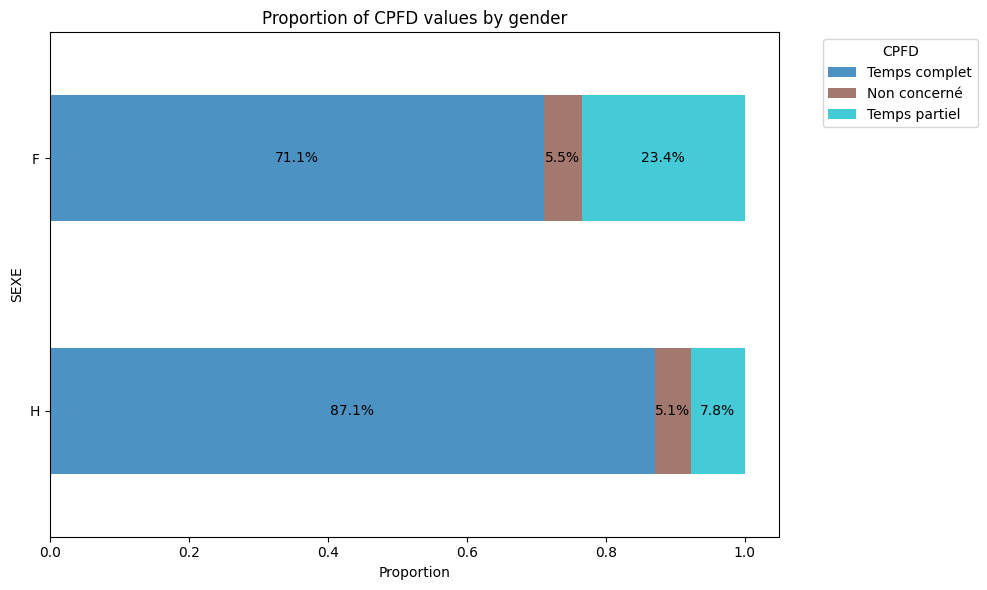

In [ ]:
# Temporary db to compute the proportions of CPFD values
age_cpfd_counts = base.groupby(['SEXE', 'CPFD']).size().unstack(fill_value=0)
age_cpfd_proportions = age_cpfd_counts.div(age_cpfd_counts.sum(axis=1), axis=0)

age_cpfd_proportions.plot(kind='barh', stacked=True, figsize=(10, 6), colormap='tab10', alpha=0.8,)
custom_legend = ['Temps complet', 'Non concerné', 'Temps partiel']#~C,N,P
plt.yticks(ticks=[0, 1], labels=["H", "F"]) 
plt.title('Proportion of CPFD values by gender')
plt.xlabel('Proportion')
plt.ylabel('SEXE')
plt.legend(title='CPFD', bbox_to_anchor=(1.05, 1), loc='upper left', labels = custom_legend)
for i, (row_name, row_data) in enumerate(age_cpfd_proportions.iterrows()):
    cumulative_sum = 0
    for j, (col_name, value) in enumerate(row_data.items()):
        cumulative_sum += value
        percentage = value * 100
        plt.text(cumulative_sum - value / 2, i, f'{percentage:.1f}%', 
                horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

With further granulation :

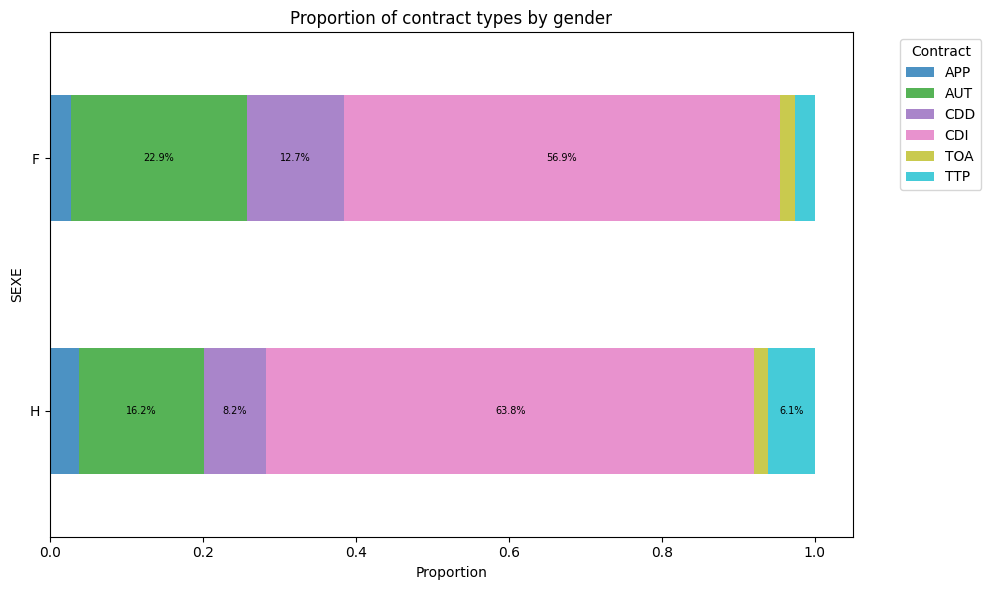

In [ ]:
#Grouping by types of work contract
age_cpfd_counts = base.groupby(['SEXE', 'CONT_TRAV']).size().unstack(fill_value=0)
age_cpfd_proportions = age_cpfd_counts.div(age_cpfd_counts.sum(axis=1), axis=0)

age_cpfd_proportions.plot(kind='barh', stacked=True, figsize=(10, 6), colormap='tab10', alpha=0.8,)
plt.yticks(ticks=[0, 1], labels=["H", "F"]) 
plt.title('Proportion of contract types by gender')
plt.xlabel('Proportion')
plt.ylabel('SEXE')
plt.legend(title='Contract', bbox_to_anchor=(1.05, 1), loc='upper left')
for i, (row_name, row_data) in enumerate(age_cpfd_proportions.iterrows()):
    cumulative_sum = 0
    for j, (col_name, value) in enumerate(row_data.items()):
        cumulative_sum += value
        percentage = value * 100
        if value > 0.05:  # Display only for percentages > 5% for better readability
            plt.text(cumulative_sum - value / 2, i, f'{percentage:.1f}%', 
                    horizontalalignment='center', verticalalignment='center', fontsize=7, color='black')

plt.tight_layout()
plt.show()

Women are more enclined to work in a non-stable contract : they are more represented in the 'Autres' and 'CDD' types.

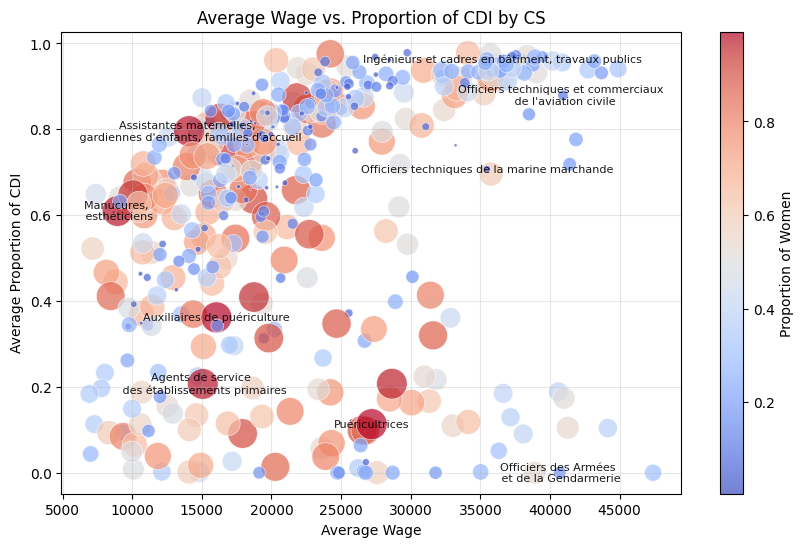

In [ ]:
# Group the data by 'CS' and compute the relevant metrics
grouped = base.groupby('PCS').agg(
    avg_wage=('WAGE', 'mean'),
    avg_cdd_proportion=('CONT_TRAV', lambda x: (x == 'CDI').mean()),
    women_proportion=('SEXE', lambda x: (x == 2).mean())
).reset_index()

grouped_sorted = grouped.sort_values(by='women_proportion', ascending=False)
top_csp = pd.concat([
    grouped_sorted.head(5),  
    grouped_sorted[grouped_sorted['avg_wage'] > 35000].tail(3),  
    grouped_sorted[(grouped_sorted['avg_wage'] > 35000) & (grouped_sorted['avg_cdd_proportion'] < 0.2)].tail(1)
])#Selection of conditions made arbitrarily
plt.figure(figsize=(10, 6))
plt.scatter(
    x=grouped['avg_wage'], 
    y=grouped['avg_cdd_proportion'], 
    s=grouped['women_proportion'] * 500,  # Size
    c=grouped['women_proportion'],  # Color
    cmap='coolwarm', alpha=0.7, edgecolors='w', linewidth=0.5
)

custom_labels = {
    '563A': "Assistantes maternelles, \n gardiennes d'enfants, familles d'accueil",
    '562A': 'Manucures, \n esthéticiens',
    '526C': 'Auxiliaires de puériculture',
    '525A': 'Agents de service \n des établissements primaires',
    '431C': 'Puéricultrices',
    '382D': 'Ingénieurs et cadres en bâtiment, travaux publics',
    '389B': "Officiers techniques et commerciaux \n de l'aviation civile",
    '389C': 'Officiers techniques de la marine marchande',
    '334A': 'Officiers des Armées \n et de la Gendarmerie'
}#Manually determined
for i, row in top_csp.iterrows():
    label = row['PCS']  # Default label as CS value
    if label in custom_labels:
        label = custom_labels[label]  # Replace with custom label if it exists in custom_labels dict
    plt.text(
        row['avg_wage'], row['avg_cdd_proportion'], 
        label, ha='center', va='center', fontsize=8, color='black', 
        alpha=0.9
    )
plt.title("Average Wage vs. Proportion of CDI by CS")
plt.xlabel("Average Wage")
plt.ylabel("Average Proportion of CDI")
plt.colorbar(label="Proportion of Women")  # Add color bar to indicate the proportion of women
plt.grid(True, alpha=0.3)
plt.show()


Professions that are predominantly female (represented by large red points), such as childcare workers and nursery assistants, often have lower wages and a variable proportion of permanent contracts (CDI). Some have a proportion of CDIs under 20%.

Higher-paying jobs, located on the right side of the graph, are generally male-dominated. They do not all tend to be structured with a high proportion of permanent contracts, such as military officers and law enforcement.

The number of employees is binned in 7 categories :

In [44]:
base['TREFF'].unique()

array([ 6.,  3.,  4.,  5.,  1.,  0.,  2., nan])

All else being equal, the following graph shows that changing from one bin to another increases the mean wage, by roughly 1700 €. The coefficient is highly significant (the p-value is < 0.001).

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\grnma\AppData\Local\Temp\ipykernel_16708\3634854291.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\grnma\AppData\Local\Temp\ipykernel_16708\3634854291.py:9: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\grnma\Ap

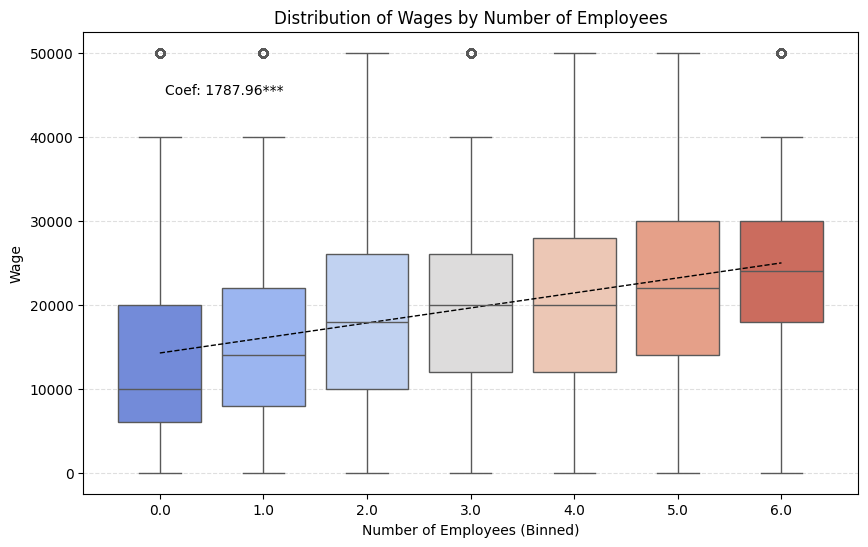

In [58]:
import statsmodels.api as sm

plt.figure(figsize=(10, 6))
sns.boxplot(x="TREFF", y="WAGE", data=base, palette="coolwarm")

X = sm.add_constant(base["TREFF"])
y = base["WAGE"]
model = sm.OLS(y, X, missing='drop').fit()
coef, p_value, intercept = model.params[1], model.pvalues[1], model.params[0]

stars = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
plt.text(0.05, max(y) * 0.9, f"Coef: {coef:.2f}{stars}", fontsize=10, color="black")

x_vals = np.linspace(base["TREFF"].min(), base["TREFF"].max(), 100)
y_vals = intercept + coef * x_vals
plt.plot(x_vals, y_vals, color="black", linestyle="--", linewidth=1)

plt.xlabel("Number of Employees (Binned)")
plt.ylabel("Wage")
plt.title("Distribution of Wages by Number of Employees")

plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.show()

## DAG : causal graph and choice of covariates

To grasp the many causal relationships beteen our variables that we have exposed through this notebook, we visualize links between covariates and target variables.

In [23]:
import networkx as nx

from pgmpy.base.DAG import DAG

The complete graph can be seen below :

In [24]:
complete_digraph = nx.DiGraph(
    [
        ("AGE", "WAGE"),
        ("AGE", "SUBREGION"),
        ("AGE", "WHOURS"),
        ("AGE", "CSP"),
        ("AGE", "CONTRACT"),
        ("SEX", "WAGE"),
        ("SEX", "WHOURS"),
        ("SEX", "ACTIVITY 38"),
        ("SEX", "CSP"),
        ("SUBREGION", "WAGE"),
        ("SUBREGION", "NB EMPLOYEES"),
        ("CSP", "WAGE"),
        ("CSP", "CONV COLL"),
        ("CSP", "NB EMPLOYEES"),
        ("CSP", "WHOURS"),
        ("CONTRACT", "CSP"),
        ("CONTRACT", "WHOURS"),
        ("CONTRACT", "WAGE"),
        ("ACTIVITY 38", "CSP"),
        ("ACTIVITY 38", "WAGE"),
        ("ACTIVITY 38", "WHOURS"),
        ("ACTIVITY 38", "CONTRACT"),
        ("CONV COLL", "WAGE"),
        ("WHOURS", "WAGE"),
        ("NB EMPLOYEES", "WAGE"),
        ("SEX", "CONTRACT"),
        ("ACTIVITY 38", "CONV COLL")
    ]
)

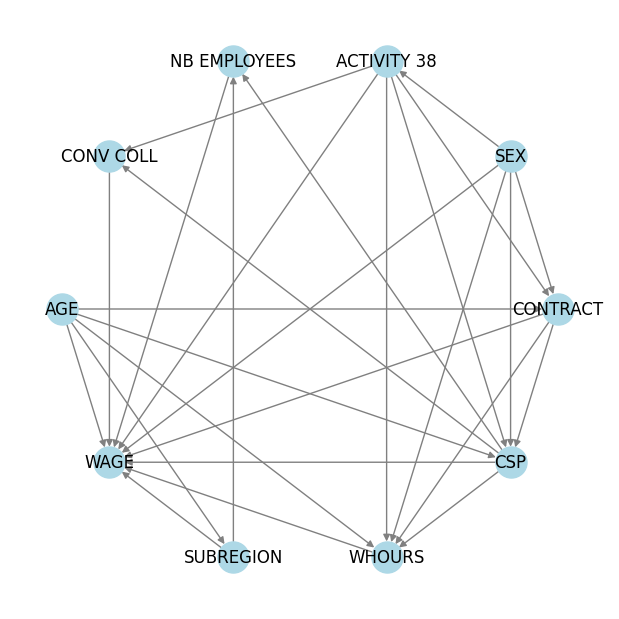

In [26]:
plt.figure(figsize=(6,6))

pos = nx.shell_layout(complete_digraph)
 # layout for reproducibility and visibility

nx.draw(complete_digraph, pos, with_labels=True, node_color='lightblue',
edge_color='gray', node_size=500)

plt.show()

One can also plot this graph, excluding 'WHOURS' from the analysis.

In [27]:
wage_digraph = nx.DiGraph(
    [
        ("AGE", "WAGE"),
        ("AGE", "SUBREGION"),
        ("AGE", "CSP"),
        ("AGE", "CONTRACT"),
        ("SEX", "WAGE"),
        ("SEX", "ACTIVITY 38"),
        ("SEX", "CSP"),
        ("SUBREGION", "WAGE"),
        ("SUBREGION", "NB EMPLOYEES"),
        ("CSP", "WAGE"),
        ("CSP", "CONV COLL"),
        ("CSP", "NB EMPLOYEES"),
        ("CONTRACT", "CSP"),
        ("CONTRACT", "WAGE"),
        ("ACTIVITY 38", "CSP"),
        ("ACTIVITY 38", "WAGE"),
        ("ACTIVITY 38", "CONTRACT"),
        ("CONV COLL", "WAGE"),
        ("NB EMPLOYEES", "WAGE"),
        ("SEX", "CONTRACT"),
        ("ACTIVITY 38", "CONV COLL")
    ]
)

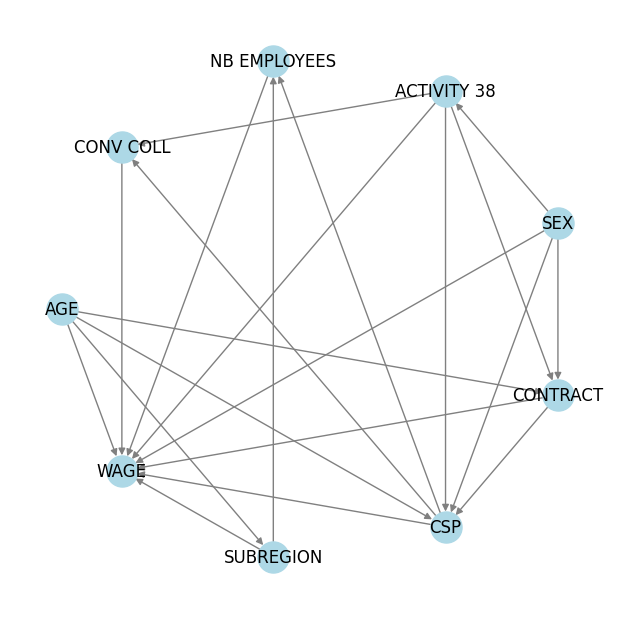

In [28]:
plt.figure(figsize=(6,6))

pos = nx.shell_layout(wage_digraph)

nx.draw(wage_digraph, pos, with_labels=True, node_color='lightblue',
edge_color='gray', node_size=500)

plt.show()

Here, excluding wage from the analysis.

In [39]:
whours_digraph = nx.DiGraph(
    [
        ("AGE", "WHOURS"),
        ("AGE", "CSP"),
        ("AGE", "CONTRACT"),
        ("SEX", "WHOURS"),
        ("SEX", "ACTIVITY 38"),
        ("SEX", "CSP"),
        ("CSP", "CONV COLL"),
        ("CSP", "WHOURS"),
        ("CONTRACT", "CSP"),
        ("CONTRACT", "WHOURS"),
        ("ACTIVITY 38", "CSP"),
        ("ACTIVITY 38", "WHOURS"),
        ("ACTIVITY 38", "CONTRACT"),
        ("SEX", "CONTRACT"),
        ("ACTIVITY 38", "CONV COLL")
    ]
)

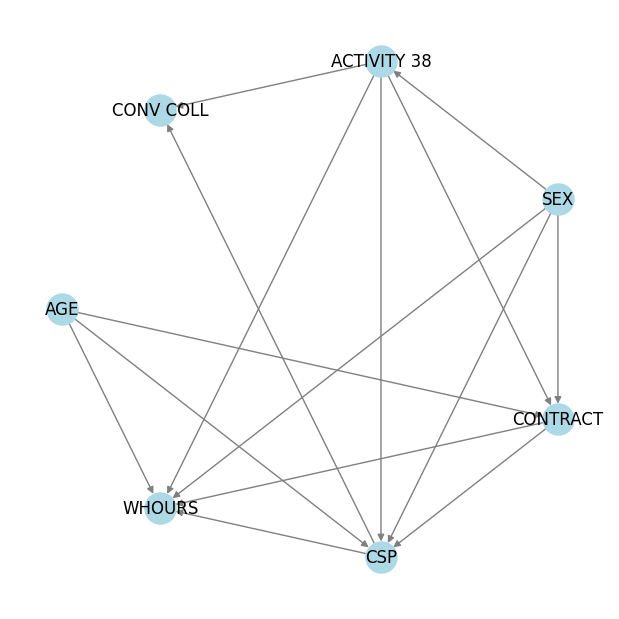

In [40]:
plt.figure(figsize=(6,6))

pos = nx.shell_layout(whours_digraph)

nx.draw(whours_digraph, pos, with_labels=True, node_color='lightblue',
edge_color='gray', node_size=500)

plt.show()